IndexInfoRX connected.
distance=1135m, pfx=3, data=2
distance=1310m, pfx=3, data=3
distance=1163m, pfx=3, data=1
distance=1147m, pfx=3, data=2
distance=1266m, pfx=3, data=3
distance=1114m, pfx=3, data=1
distance=1189m, pfx=3, data=2
distance=1246m, pfx=3, data=3
distance=1264m, pfx=3, data=1
distance=1110m, pfx=3, data=2
distance=1247m, pfx=3, data=3
distance=1254m, pfx=3, data=1
distance=1190m, pfx=3, data=2
distance=1236m, pfx=3, data=3
distance=1214m, pfx=3, data=1
distance=1196m, pfx=3, data=2
distance=1238m, pfx=3, data=3
distance=1209m, pfx=3, data=1
distance=1208m, pfx=3, data=2
distance=1246m, pfx=3, data=3
distance=1249m, pfx=3, data=1
distance=1159m, pfx=3, data=2
distance=1235m, pfx=3, data=3
distance=1208m, pfx=3, data=1
distance=1153m, pfx=3, data=2
distance=1237m, pfx=3, data=3
distance=1240m, pfx=3, data=1
distance=1190m, pfx=3, data=2
distance=1282m, pfx=3, data=3
distance=1250m, pfx=3, data=1
distance=1226m, pfx=3, data=2
distance=1264m, pfx=3, data=3
distance=1247m, p

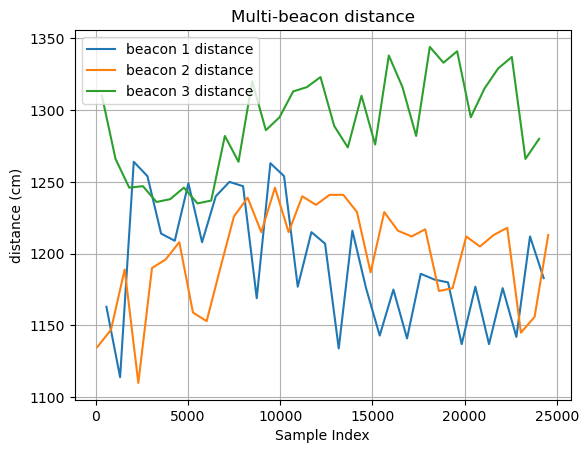

In [ ]:
from range import RangeCalc
import numpy as np
from numpy.fft import rfft
from numpy.fft import fftfreq
from matplotlib import pyplot as plt
import pandas as pd
import time

rc = RangeCalc("COM3", 115200, 10, 30.012)

# Initialize live plot
plt.ion()
fig, ax = plt.subplots()
distance1, distance2, distance3, t1,t2,t3 = [], [], [], [], [], []

line1, = ax.plot(t1, distance1, label="beacon 1 distance")
line2, = ax.plot(t2, distance2, label="beacon 2 distance")
line3, = ax.plot(t3, distance3, label="beacon 3 distance")

ax.set_xlabel("Sample Index")
ax.set_ylabel("distance (cm)")
ax.set_title("Multi-beacon distance")
ax.legend()
ax.grid()
i=0
start_time = time.perf_counter()
while i <100:  
    #distance, pfx, data = rc.debug_read()
    distance, pfx, data = rc.read_range_and_beacon_id()
    i+=1
    print(f"distance={distance}m, pfx={pfx}, data={data}")  # Print the filtered value
    curren_time = time.perf_counter()
    elapsed_ms = (curren_time - start_time) * 1000
    # Update plot data
    if data==1:
        distance1.append(distance)
        t1.append(elapsed_ms)
    elif data==2:
        distance2.append(distance)
        t2.append(elapsed_ms)
    elif data==3:
        distance3.append(distance)
        t3.append(elapsed_ms)

    line1.set_xdata(t1)
    line1.set_ydata(distance1)
    line2.set_xdata(t2)
    line2.set_ydata(distance2)
    line3.set_xdata(t3)
    line3.set_ydata(distance3)
    ax.relim()
    ax.autoscale_view()
    #plt.draw()
    # plt.pause(0.01)  # Adjust for smoother updates

plt.ioff()
plt.show()
np.savez('distances.npz', d1=np.array(distance1), d2=np.array(distance2), d3=np.array(distance3), t1=np.array(t1),t2=np.array(t2),t3=np.array(t3))

In [31]:
def trilateration_3d(P1, P2, P3, d1, d2, d3):
    # Convert points to numpy arrays
    P1 = np.array(P1)
    P2 = np.array(P2)
    P3 = np.array(P3)

    # Unit vector in direction from P1 to P2
    ex = (P2 - P1)
    ex = ex / np.linalg.norm(ex)

    # Vector from P1 to P3
    P3_P1 = P3 - P1

    # Project P3_P1 onto ex to find i
    i = np.dot(ex, P3_P1)

    # Vector in the P1-P3 plane orthogonal to ex
    temp = P3_P1 - i * ex
    ey = temp / np.linalg.norm(temp)

    # ez is the cross product of ex and ey
    ez = np.cross(ex, ey)

    # Coordinates in new basis
    d = np.linalg.norm(P2 - P1)
    j = np.dot(ey, P3_P1)

    # Coordinates of drone in local coordinate system
    x = (d1**2 - d2**2 + d**2) / (2 * d)
    y = (d1**2 - d3**2 + i**2 + j**2 - 2 * i * x) / (2 * j)

    # Calculate z coordinate
    z_sq = d1**2 - x**2 - y**2
    if z_sq < 0:
        z_sq = 0
    z = np.sqrt(z_sq)

    # Convert back to original coordinate system
    coordinates = P1 + x * ex + y * ey + z * ez
    return coordinates

from scipy.optimize import least_squares

def trilateration_least_squares(beacons, distances):
    def residuals(pos):
        return [np.linalg.norm(pos - beacon) - dist for beacon, dist in zip(beacons, distances)]
    
    # Initial guess: centroid of beacons
    x0 = np.mean(beacons, axis=0)
    
    result = least_squares(residuals, x0)
    return result.x

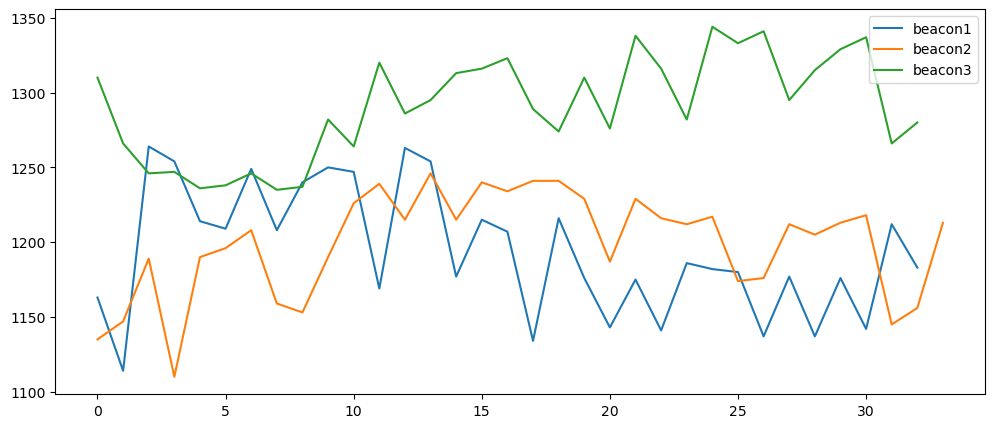

In [37]:
P1 = np.array([-.3, 0, 0])
P2 = np.array([-.2, 0, 0])
P3 = np.array([-.1, 0, 0])
beacons = np.array([P1,P2,P3])
data = np.load('distances.npz')
distance1, distance2, distance3, t1, t2, t3 = data['d1'],data['d2'],data['d3'],data['t1'],data['t2'],data['t3']
plt.figure(figsize=(12,5))
plt.plot(distance1,label='beacon1')
plt.plot(distance2,label='beacon2')
plt.plot(distance3,label='beacon3')
plt.legend()
plt.show()
#plt.ylim(0.18, 0.2)
#plt.ylim(0.25, 0.28)
#plt.ylim(0.2, 0.3)

In [38]:
def read_range_and_beacon_id(buf_idx):
    pre_idx = 3
    tmsp_ping_rx = pre_idx * 18000 + buf_idx
    dt = tmsp_ping_rx/1.38e6
    distance = 0.5 * dt * 1500 - 30.012
    return distance
def process_data(dis):
    for i in range(len(dis)):
        dis[i] = read_range_and_beacon_id(dis[i])
    return dis
distance1=process_data(distance1)
distance2=process_data(distance2)
distance3=process_data(distance3)


In [39]:
L = min(len(distance1),len(distance2),len(distance3))
Trilater_drone_path = np.zeros((L,3))
for i in range(L):
    Trilater_drone_path[i,:] = trilateration_least_squares(beacons,np.array([distance1[i], distance2[i], distance3[i]]))

In [50]:
d1=distance1[distance1>0.18]
d1=d1[d1<0.2]
d2=distance2[distance2>0.25]
d2=d2[d2<0.28]
d3=distance3[distance3>0.22]
d3=d3[d3<0.3]
offset = -0.01
print(np.average(d1)-offset)
print(np.average(d2)-offset)
print(np.average(d3)-offset)

0.20068878718535477
0.27607971014492727
0.27671237458193937


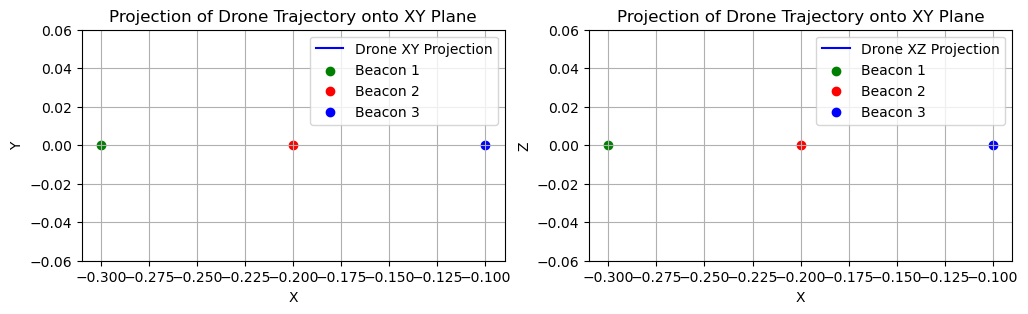

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.plot(Trilater_drone_path[:,0], Trilater_drone_path[:,1], label='Drone XY Projection', color='blue')
plt.scatter(P1[0], P1[1], c='green', label='Beacon 1')
plt.scatter(P2[0], P2[1], c='red', label='Beacon 2')
plt.scatter(P3[0], P3[1], c='blue', label='Beacon 3')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Projection of Drone Trajectory onto XY Plane")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.subplot(1,2,2)
plt.plot(Trilater_drone_path[:,0], Trilater_drone_path[:,2], label='Drone XZ Projection', color='blue')
plt.scatter(P1[0], P1[1], c='green', label='Beacon 1')
plt.scatter(P2[0], P2[1], c='red', label='Beacon 2')
plt.scatter(P3[0], P3[1], c='blue', label='Beacon 3')
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Projection of Drone Trajectory onto XY Plane")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.show()

In [36]:
import plotly.graph_objects as go
import numpy as np

# Create plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=Trilater_drone_path[:,0], y=Trilater_drone_path[:,1], z=Trilater_drone_path[:,2],
    mode='lines',
    name='Drone Path',
    line=dict(color='blue')
))
beacons=np.array([P1,P2,P3])
fig.add_trace(go.Scatter3d(
    x=beacons[:,0], y=beacons[:,1], z=beacons[:,2],
    mode='markers',
    name='Beacons',
    marker=dict(size=5, color=['green','red','blue'])
))

fig.update_layout(
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    title='Interactive 3D Drone Trajectory',
    width=800,
    height=600,

)

fig.show()
